In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import h5py
import os
from PIL import Image
import matplotlib.pyplot as plt
import json
import torch
from tqdm import tqdm
from typing import List, Union

In [3]:
class Colors:
    """ Helper class for colors. Provides mappings from sensor ids to colors as well as colors for the individual classes.
    """

    red = "#f02b2b"
    blue = "#4763ff"
    green = "#47ff69"
    light_green = "#73ff98"
    orange = "#ff962e"
    violet = "#c561d4"
    indigo = "#8695e3"
    grey = "#7f8c8d"
    yellow = "#ffff33"
    lime = "#c6ff00"
    amber = "#ffd54f"
    teal = "#19ffd2"
    pink = "#ff6eba"
    brown = "#c97240"
    black = "#1e272e"
    midnight_blue = "#34495e"
    deep_orange = "#e64a19"
    light_blue = "#91cded"
    light_gray = "#dedede"
    gray = "#888888"

    sensor_id_to_color = {
        1: red,
        2: blue,
        3: green,
        4: pink
    }

    label_id_to_color = {
        0: violet,
        1: orange,
        2: green,
        3: pink,
        4: light_blue,
        5: gray,
        6: brown,
        7: yellow,
        8: light_green,
        9: blue,
        10: indigo,
        11: teal
    }

    object_colors = [red, blue, green, light_green, orange, violet, yellow, teal, pink, brown,
                     light_blue, lime, deep_orange, amber, indigo]

In [4]:
class RadarPointCloud():
    """ Point cloud containing all features / radar channels of the RadarScenes dataset.

    Methods:
        remove_points_without_labelID: Removes all points without a valid label ID.
        remove_points_without_valid_velocity: Removes all points without doppler velocity.
        remove_points_out_of_range: Removes points based on their distance to the car-coordinate-system origin.
        remove_points_based_on_index: Removes points defined by their index.
        show: Visualize the point cloud.
    """

    def __init__(self):
        self.X_cc = None
#         self.X_seq = None
        self.X_car = None
        self.Y_car = None

        self.V_cc = None
        self.V_cc_compensated = None

        self.range_sc = None
        self.azimuth_sc = None
        self.rcs = None

        self.vr = None
        self.vr_compensated = None

        self.timestamp = None
        self.sensor_id = None

        self.uuid = None
        self.track_id = None
        self.label_id = None

    def remove_points_without_labelID(self) -> None:
        """ Removes all points with a "non" class label.

        Note:
            This results from using reduced labels (clabel) where e.g. the class "animal" becomes none
        """
        idx_rmv = np.where(np.isnan(self.label_id[:, 0]))[0]
        self.remove_points_based_on_index(idx_rmv)

    def remove_points_without_valid_velocity(self) -> None:
        """ Removes all points with a "non" velocity.

        Note:
            This results from using reduced labels (clabel) where e.g. the velocity of "animal" becomes none
        """
        idx_rmv_1 = np.where(np.isnan(self.V_cc_compensated[:, 0]))[0]
        idx_rmv_2 = np.where(np.isnan(self.V_cc_compensated[:, 1]))[0]
        idx_rmv = np.unique(np.concatenate((idx_rmv_1, idx_rmv_2), axis=0))

        self.remove_points_based_on_index(idx_rmv)

    def remove_points_out_of_range(self, x_max: float, y_max: float) -> None:
        """ Removes radar points based on their location.

        Removes all points that are:
            - further away than x_max or y_max from the car
            - behind the car -> x < 0
        """

        idx_inv1 = np.where(abs(self.X_cc[:, 1]) > y_max)[0]
        idx_inv2 = np.where(self.X_cc[:, 0] > x_max)[0]
        idx_inv3 = np.where(self.X_cc[:, 0] < 0)[0]
        idx_inv = np.concatenate([idx_inv1, idx_inv2, idx_inv3], axis=0)
        idx_inv = np.unique(idx_inv)
        self.remove_points_based_on_index(idx_inv)

    def remove_points_based_on_index(self, idx_array: np.ndarray) -> None:
        """ Remove points by their index.
        """

        for key in vars(self).keys():
            if vars(self).get(key) is not None:
                vars(self)[key] = np.delete(vars(self)[key], idx_array, axis=0)

    def show(self, show_velocity_vector=False) -> None:

        # convert label IDs to colors
        colors = Colors()
        c = [colors.label_id_to_color[id[0]] for id in self.label_id]

        # create and show plot
        fig, ax = plt.subplots()
        ax.scatter(self.X_cc[:, 0], self.X_cc[:, 1], c=c)
        ax.scatter(0, 0, c='black')
        if show_velocity_vector:
            ax.quiver(self.X_cc[:, 0], self.X_cc[:, 1], self.V_cc_compensated[:, 0], self.V_cc_compensated[:, 1], scale=150)
        ax.axis("equal")

        return fig, ax

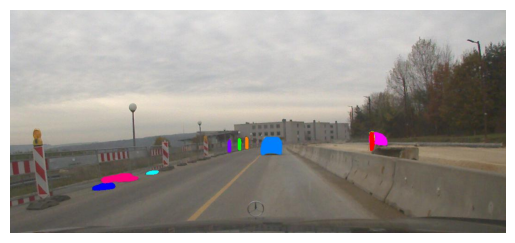

In [5]:


# Specify the image path
image_path = "/kaggle/input/the-radarscenes-data-set/data/data/sequence_1/camera/156859092964.jpg"

# Open the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()


# 3.2 RadarScenes Introduction

## 3.2.1 Sensor Settings

Here’s how these sensors work:

Where the sensors are: The toy car has four sensors attached to the front. They can "see" up to 100 meters ahead, which is like looking down a very long football field. They can also see wide, covering 60 degrees on each side—so they don’t just look straight ahead but also to the sides, a bit like having wide-angle vision.

How well the sensors see:

The sensors are really good at telling how far things are. They can figure out the distance between the car and other objects with great accuracy, like being able to tell if something is just 15 centimeters (or half a ruler) closer or farther away.
They can also tell how fast something is moving, even if it’s just moving by 0.1 km/h (which is very slow, like walking speed).
How clear the sensors are:

When things are right in front of the car, the sensors can "see" very clearly, almost like high-definition TV.
But, when something is further to the side, the sensors become a bit less clear, like when you're trying to read a sign that's far away.
How fast they work: These sensors check the surroundings really fast—they update every 60 milliseconds (which is faster than the blink of an eye). And because there are four sensors, they take turns updating, so the car always has the latest information about what's in front of it.

In addition to the sensors on the car, there's also a camera placed behind the windshield, just like a dashcam. This camera is always looking at the road ahead and recording what's happening, like filming the traffic in front of the car.

Now, the car itself is moving, right? It's not just sitting still. As it moves, it collects information about:

Where the car is (its position) Which direction the car is facing How fast the car is going (its speed) How much the car is turning (the yaw rate, which means how much the car is rotating or changing direction) With all this information about the car's movement, the car can make sure the radar sensors' data is accurate. This is important because, if the car is moving, the radar readings can change. So, by using the car’s motion data, the sensors can adjust their measurements to match the real-world positions of things around the car. It's like making sure you know exactly where everything is on a map, even if you're moving around while looking at it.

## 3.2.2 Data Structure

## RadarScenes Dataset Explained

The **RadarScenes** dataset is like a big collection of recordings, with **158 different clips or sequences**. Each of these clips shows different traffic situations, lasting anywhere between **13 seconds and 4 minutes**. These recordings were made using sensors on a car, and they contain information about objects the sensors detected, like cars or buildings. The data is stored in a special type of file called an **HDF5 file**, and you can load it with tools to see it as a big table, kind of like a spreadsheet.

## Reflection Points
Each row in the table is about one specific thing the radar detected, called a **reflection point**. The radar sensors detect objects by bouncing signals off them, and each reflection point has some important information:

### Key Information in Each Reflection Point

- **Timestamp**: 
  - When exactly the sensor saw the reflection, in tiny units of time (**microseconds**).

- **Sensor ID**: 
  - Tells you which of the **4 sensors** (on the front of the car) saw this reflection.

- **Range**: range sc
  - How far the object is from the car, measured in **meters**.

- **Azimuth**: 
  - The **angle** between the object and the direction the car is facing.

- **RCS (Radar Cross Section)**: 
  - How big or strong the reflection was, like how much radar energy bounced back.

- **Radial Velocity (vr)**: 
  - How fast the object is moving, either **toward or away** from the car.

- **Position (x, y) in the car's view**: x_cc, y_cc
  - Where the object is, based on the car's own position.

- **Position in the world**: x_seq and y_seq 
  - Where the object is in the **bigger world**, not just in relation to the car.

- **UUID**: 
  - A unique ID or name for the reflection point so you can tell it apart from others.

- **Track ID**: 
  - If the object is moving (like another car), this ID groups points from the same object together. If it's **empty**, the object is not moving (static).

- **Label ID**: 
  - This number says **what kind of object** it is (like a person, car, building, etc.), with IDs ranging from **0 to 11** for different types of things.


# 3.2.3 Annotations

# Understanding Radar Data: Reflection Points, Label IDs, and Track IDs

Imagine the radar is like a camera that takes pictures of things around a car, but instead of taking photos, it sends out signals and listens for them to bounce back. When the signals hit something (like a car or a tree), they bounce back to the radar, and each bounce is called a "reflection point." The radar uses these points to figure out what's around the car.

## Two Important IDs

There are two important IDs (or labels) that help the radar understand what it's seeing:

### 1. Label ID
This is a number that tells the radar **what type of object** it is, like:
- A car
- A tree
- A person
- A building

All the points that bounce off the same object share the same **Label ID**. So, if the radar detects a car, all the points bouncing off that car will have the same Label ID.

### 2. Track ID
This ID helps the radar know **which points come from the same object**, even as it moves. 

For example, if a car drives by:
- All the points bouncing off that car get the same Track ID.
- This way, the radar knows that all these points are from the same car, even if it detects the car at different moments.

## Objects as Clusters

When the radar sees something, like a car, it doesn't just get one point. It gets **lots of points** that make up the shape of the car. All these points together form a **cluster**. You can think of a cluster as a group of points that belong to the same object. In this report, they use the words **"cluster" and "object"** to mean the same thing.

## Why This Matters

With these two labels (the Label ID and Track ID), the radar can figure out:
1. **What type of object it is** (using the Label ID).
2. **Which points belong to the same object** (using the Track ID).

This information is really important for computers that try to break down a scene into different objects, especially for models that help cars understand their surroundings better.


# RadarScenes Dataset: Understanding Road Users

RadarScenes is all about watching things that move on the road, called **dynamic road users**. These are things like cars, bikes, and people. Everything the radar sees is grouped into one of **11 categories** or classes.

## Categories of Road Users

Here are the 11 classes:

1. **Car**
2. **Large vehicle** (like big vans or trucks)
3. **Truck**
4. **Bus**
5. **Train**
6. **Bicycle**
7. **Motorized two-wheeler** (like motorcycles or scooters)
8. **Pedestrian** (people walking)
9. **Pedestrian group** (a bunch of people together)
10. **Animal** (like a dog or deer)
11. **Other** (for anything that doesn’t fit, like skaters)

### Pedestrian Group
Sometimes, the radar sees a **group of people** so close together that it can’t tell them apart. These groups are labeled as a **pedestrian group**.

## Static Objects

The radar also detects **static objects**—things that don't move, like buildings or trees. These objects get a **static label**, meaning they aren't considered road users.

## Simplified Categories

To make things easier, there’s a way to group these 11 classes into just **5 bigger categories**:

1. **Car**
2. **Large vehicle**
3. **Two-wheeler** (bikes, motorcycles, etc.)
4. **Pedestrian**
5. **Pedestrian group**

This simpler system helps balance the number of samples in each class, which is really useful for object detection. For example, there might be a lot of cars but fewer trains, so having fewer categories helps the system better recognize different things on the road.


# Ego-Motion Compensation Explained

- **Doppler Effect**: Imagine you’re standing still and a car drives past you honking its horn. The sound changes as the car moves. This change is called the Doppler effect. Similarly, radar sensors use this effect to measure how fast objects are moving towards or away from them.
- **Ego-Motion**: Now, imagine you’re in a car that’s moving. The radar sensor on your car is also moving with you. So, when the sensor measures the speed of an object, it also includes the speed of your car. This is called ego-motion.
- **Compensation**: To get the true speed of the object, we need to remove the effect of your car’s movement. This is called ego-motion compensation.
- **Calculation**: To do this, we subtract the speed of stationary objects (like a parked car or a tree) from the measured speed. This gives us the true speed of the moving object.

So, in simple terms, ego-motion compensation is like adjusting the radar sensor’s measurements to account for the fact that your car is moving. This helps in getting accurate speed readings of other objects around you.


In [6]:


from enum import Enum
from typing import Union


class Label(Enum):
    """
    The Labels enum contains all semantic labels available in the data set.
    """
    CAR = 0
    LARGE_VEHICLE = 1
    TRUCK = 2
    BUS = 3
    TRAIN = 4
    BICYCLE = 5
    MOTORIZED_TWO_WHEELER = 6
    PEDESTRIAN = 7
    PEDESTRIAN_GROUP = 8
    ANIMAL = 9
    OTHER = 10
    STATIC = 11

    @staticmethod
    def label_id_to_name(label_id: int) -> str:
        """
        Convert an integer label_id to the string representation of the corresponding enum
        :param label_id: Label ID of a class for which a string is desired.
        :return: The class name as a string
        """
        return Label(label_id).name


class ClassificationLabel(Enum):
    """
    This Enum contains a subset of the complete label hierarchy. All classes from the "Labels" enum are mapped
    to a set of 6 different classes.
    This set of labels may be used for machine learning based classification tasks to reduce complexity .
    Mappings to "None" indicate that this class should be omitted in training/evaluation.
    """
    CAR = 0
    PEDESTRIAN = 1
    PEDESTRIAN_GROUP = 2
    TWO_WHEELER = 3
    LARGE_VEHICLE = 4
    STATIC = 5

    @staticmethod
    def label_to_clabel(label: Union[Label, int]) -> "ClassificationLabel":
        """
        Convert a member of the Labels enum to a ClassificationLabel
        :param label: Label that shall be translated. Can be either a "Label" instance or an integer representation
        of a Label
        :return: a ClassificationLabel
        """
        dic = ClassificationLabel.translation_dict()
        if not isinstance(label, Label):
            label = Label(label)
        return dic[label]

    @staticmethod
    def translation_dict() -> dict:
        """
        Provides the translation from Label to ClassificationLabel
        :return: a dictionary with Label instances as key and a ClassificationLabel as value.
        """
        return {
            Label.CAR: ClassificationLabel.CAR,
            Label.LARGE_VEHICLE: ClassificationLabel.LARGE_VEHICLE,
            Label.TRUCK: ClassificationLabel.LARGE_VEHICLE,
            Label.BUS: ClassificationLabel.LARGE_VEHICLE,
            Label.TRAIN: ClassificationLabel.LARGE_VEHICLE,
            Label.BICYCLE: ClassificationLabel.TWO_WHEELER,
            Label.MOTORIZED_TWO_WHEELER: ClassificationLabel.TWO_WHEELER,
            Label.PEDESTRIAN: ClassificationLabel.PEDESTRIAN,
            Label.PEDESTRIAN_GROUP: ClassificationLabel.PEDESTRIAN_GROUP,
            Label.ANIMAL: None,
            Label.OTHER: None,
            Label.STATIC: ClassificationLabel.STATIC
        }

    @staticmethod
    def label_id_to_name(cl_label_id: int) -> str:
        """
        Convert an integer classification_label_id to the string representation of the corresponding enum
        :param cl_label_id: Label ID of a class for which a string is desired.
        :return: The class name as a string
        """
        return ClassificationLabel(cl_label_id).name


In [7]:
filename = '/kaggle/input/the-radarscenes-data-set/data/data/sequence_1/radar_data.h5'

with h5py.File(filename, "r") as f:
    radar_data = f["radar_data"][:]
#             self.odometry_data = f["odometry"][:]

# radar_df = pd.DataFrame(radar_data)
# radar_df[radar_df['sensor_id'] == 1]
# radar_df_sensor_1 = radar_df[radar_df['sensor_id'] == 1]

# radar_df_sensor_1
# print(len(radar_df_sensor_1))
# timestamps = radar_data["timestamp"]
# timestamps
# radar_data

In [8]:
import json

RADAR_DEFAULT_MOUNTING = {
    1: {"x": 3.663, "y": -0.873, "yaw": -1.48418552},
    2: {"x": 3.86, "y": -0.70, "yaw": -0.436185662},
    3: {"x": 3.86, "y": 0.70, "yaw": 0.436},
    4: {"x": 3.663, "y": 0.873, "yaw": 1.484},
}


def get_mounting(sensor_id: int, json_path=None) -> dict:
    """
    Returns the sensor mounting positions of a single sensor with id sensor_id.
    The positions and the azimuth angle are given relative to the car coordinate system.
    :param sensor_id: Integer sensor id.
    :param json_path: str, path to the sensor.json file. If not defined, the default mounting positions are used.
    :return: dictionary containing the x and y position of the sensor in car coordinates as well as the yaw angle:
            structure: {"x": x_val, "y": y_val, "yaw": yaw_val}
    """
    if json_path is None:
        return RADAR_DEFAULT_MOUNTING[sensor_id]
    else:
        with open(json_path, "r") as f:
            data = json.load(f)
        radar_name = "radar_{}".format(sensor_id)
        if radar_name in data:
            return data[radar_name]
        else:
            raise KeyError("Radar {} does not exist in the json file {}.".format(radar_name, json_path))

In [9]:
json_path = "/kaggle/input/the-radarscenes-data-set/data/data/sensors.json"
sensor_id = 1
aa = get_mounting(sensor_id, json_path)
aa

{'id': 1, 'x': 3.663, 'y': -0.873, 'yaw': -1.48418552}

In [10]:
# radar_dir = "/kaggle/input/the-radarscenes-data-set/data/", 
def batch_transform_3d_vector(trafo_matrix: np.ndarray, vec: np.ndarray) -> np.ndarray:
    """
    Applies a 3x3 transformation matrix to every (1,3) vector contained in vec.
    Vec has shape (n_vec, 3)
    :param trafo_matrix: numpy array with shape (3,3)
    :param vec: numpy array with shape (n_vec, 3)
    :return: Transformed vector. Numpy array of shape (n_vec, 3)
    """
    return np.einsum('ij,kj->ki', trafo_matrix, vec)


def trafo_matrix_seq_to_car(odometry: np.ndarray) -> np.ndarray:
    """
    Computes the transformation matrix from sequence coordinates to car coordiantes, given an odometry entry.
    :param odometry: Numpy array containing at least the names fields "x_seq", "y_seq" and "yaw_seq" which give the
    position and orientation of the sensor vehicle.
    :return: Numpy array with shape (3,3), the transformation matrix. Last column is the translation vector.
    """
    x_car = odometry["x_seq"]
    y_car = odometry["y_seq"]
    yaw_car = odometry["yaw_seq"]
    c = np.cos(yaw_car)
    s = np.sin(yaw_car)
    return np.array([[c, s, -x_car * c - y_car * s],
                     [-s, c, x_car * s - y_car * c],
                     [0, 0, 1]])


def transform_detections_sequence_to_car(x_seq: np.ndarray, y_seq: np.ndarray, odometry: np.ndarray):
    """
    Computes the transformation matrix from sequence coordinates (global coordinate system) to car coordinates.
    The position of the car is extracted from the odometry array.
    :param x_seq: Shape (n_detections,). Contains the x-coordinate of the detections in the sequence coord. system.
    :param y_seq: Shape (n_detections,). Contains the y-coordinate of the detections in the sequence coord. system.
    :param odometry: Numpy array containing at least the names fields "x_seq", "y_seq" and "yaw_seq" which give the
    position and orientation of the sensor vehicle.
    :return: Two 1D numpy arrays, both of shape (n_detections,). The first array contains the x-coordinate and the
    second array contains the y-coordinate of the detections in car coordinates.
    """
    trafo_matrix = trafo_matrix_seq_to_car(odometry)
    x_seq = x_seq.reshape(-1)
    y_seq = y_seq.reshape(-1)
    v = np.ones((len(x_seq), 3))
    v[:, 0] = x_seq
    v[:, 1] = y_seq
    res = batch_transform_3d_vector(trafo_matrix, v)
    return res[:, 0], res[:, 1]

In [11]:
class Scene:
    """
    A small wrapper class for a single Scene.
    """
    def __init__(self):
        self.timestamp = None
        self.odometry_timestamp = None
        self.radar_data = None
        self.odometry_data = None
        self.camera_image_name = None
        self.sensor_id = None

In [12]:
class Sequence:
    """
    Wrapper class for a measurement sequence.
    Usually, this class should be constructed from a *.json file from the RadarScenes dataset.
    """

    def __init__(self):
        self.sequence_name = None
        self.radar_data = None
        self.odometry_data = None
        self.first_timestamp = None
        self.last_timestamp = None
        self._scenes = {}
        self._data_folder = ""
        self._current_timestamp = None

    def __len__(self):
        """
        Returns the length of a sequence in terms of number of scenes.
        :return: Number of scenes within this sequence
        """
        return len(self._scenes)

    @classmethod
    def from_json(cls, filename: str) -> "Sequence":
        """
        Create a Sequence object from a *.json file.
        Usually, this should be a scenes.json file from one sequence of the RadarScenes dataset.
        :param filename: full path to a *.json file
        :return: Sequence object
        """
        with open(filename, "r") as f:
            json_data = json.load(f)
        sequence = cls()
        sequence.sequence_name = json_data["sequence_name"]
        sequence._scenes = json_data["scenes"]
        sequence.first_timestamp = json_data["first_timestamp"]
        sequence.last_timestamp = json_data["last_timestamp"]
        sequence._data_folder = os.path.dirname(filename)
        h5_filename = os.path.join(sequence._data_folder, "radar_data.h5")
        sequence.load_sequence_data(h5_filename)
        return sequence

    @property
    def timestamps(self) -> List[int]:
        return list(map(int, self._scenes.keys()))

    def scenes(self, sensor_id=None):
        same_sensor = sensor_id is not None
        if same_sensor and sensor_id not in {1, 2, 3, 4}:
            raise ValueError("Unknown sensor id. Valid values are 1, 2, 3, 4.")
        self._current_timestamp = self.first_timestamp
        if same_sensor:
            t_init = self.first_timestamp
            while True:
                current_scene = self.get_scene(t_init)
                if current_scene.sensor_id == sensor_id:
                    self._current_timestamp = t_init
                    break
                t_init = self.next_timestamp_after(t_init)
        while self._current_timestamp is not None:
            scene = self.get_scene(self._current_timestamp)
            self._current_timestamp = self.next_timestamp_after(self._current_timestamp, same_sensor=same_sensor)
            yield scene

    def load_sequence_data(self, filename: str) -> None:
        """
        Load contents of a *.h5 sequence file.
        Data is stored in numpy arrays.
        :param filename: Full path to a *.h5 file.
        :return: None
        """
        with h5py.File(filename, "r") as f:
            self.radar_data = f["radar_data"][:]
            self.odometry_data = f["odometry"][:]

    def next_timestamp_after(self, timestamp: Union[str, int], same_sensor=False) -> Union[int, None]:
        """
        Looks for the subsequent timestamp after a given one.
        :param timestamp: timestamp (int or str) for which the next timestamp is sought
        :param same_sensor: If True, the timestamp of the next measurement from the same sensor is returned
        :return: None, if the provided timestamp is the last timestamp in the sequence or if the timestamp does not
        exist at all. Otherwise, the next timestamp of a radar measurement is returned as an int.
        """
        timestamp = str(timestamp)
        if timestamp not in self._scenes:
            return None
        if same_sensor:
            return self._scenes[timestamp]["next_timestamp_same_sensor"]
        else:
            return self._scenes[timestamp]["next_timestamp"]

    def next_scene_after(self, timestamp: Union[str, int], same_sensor=False) -> Union[Scene, None]:
        """
        Creates the next scene following a given timestamp.
        :param timestamp: current timestamp
        :param same_sensor: If true, only the same sensor as the current one is considered.
        :return: None, if timestamp is the last timestamp in the sequence. Otherwise, a Scene object holding information
        about the next scene.
        """
        next_timestamp = self.next_timestamp_after(timestamp, same_sensor)
        return self.get_scene(next_timestamp)

    def prev_timestamp_before(self, timestamp: Union[str, int], same_sensor=False) -> Union[int, None]:
        """
        Looks for the preceding timestamp before a given one.
        :param timestamp: timestamp (int or str) for which the previous timestamp is sought
        :param same_sensor: If true, only measurements from the same sensor as the current one are considered.
        :return: None, if the provided timestamp is the first timestamp in the sequence or if the timestamp does not
        exist at all. Otherwise, the previous timestamp of a radar measurement is returned as an int.
        """
        timestamp = str(timestamp)
        if timestamp not in self._scenes:
            return None
        if same_sensor:
            return self._scenes[timestamp]["prev_timestamp_same_sensor"]
        else:
            return self._scenes[timestamp]["prev_timestamp"]

    def prev_scene_before(self, timestamp: Union[str, int], same_sensor=False) -> Union[Scene, None]:
        """
        Creates the previous scene prior to a given timestamp.
        :param timestamp: current timestamp
        :param same_sensor: If true, only measurements from the same sensor as the current one are considered.
        :return: None, if timestamp is the first timestamp in the sequence. Otherwise, a Scene object holding information
        about the previous scene.
        """
        prev_timestamp = self.prev_timestamp_before(timestamp, same_sensor)
        return self.get_scene(prev_timestamp)

    def get_scene(self, timestamp: Union[str, int]) -> Union[Scene, None]:
        """
        Constructs a Scene object for measurements of a given timestamp.
        The scene holds radar data, odometry data as well as the name of the camera image belonging to this scene.
        If the timestamp is invalid, None is returned.
        :param timestamp: The timestamp for which a scene is desired.
        :return: The Scene object or None, if the timestamp is invalid.
        """
        if timestamp is None or self.radar_data is None or self.odometry_data is None:
            return None
        timestamp = str(timestamp)
        if timestamp not in self._scenes:
            return None

        scene_dict = self._scenes[timestamp]
        scene = Scene()
        scene.timestamp = int(timestamp)
        scene.radar_data = self.radar_data[scene_dict["radar_indices"][0]: scene_dict["radar_indices"][1]]
        scene.odometry_data = self.odometry_data[scene_dict["odometry_index"]]
        scene.odometry_timestamp = scene_dict["odometry_timestamp"]
        scene.sensor_id = scene_dict["sensor_id"]
        scene.camera_image_name = os.path.join(self._data_folder, "camera", scene_dict["image_name"])

        return scene


def read_sequences_json(sequences_filename: str) -> dict:
    """
    Simple helper method to load the contents of the sequences.json file
    :param sequences_filename: full path to the sequences.json file
    :return: The contents of the as a python dictionary
    """
    with open(sequences_filename, "r") as f:
        data = json.load(f)
    return data


def get_training_sequences(sequences_filename: str) -> List[str]:
    """
    Given the path to a sequences.json file, all sequences from the category "training" are retrieved.
    :param sequences_filename: path to the sequences.json file from the RadarScenes dataset.
    :return: list of training sequence names
    """
    training_sequ = []
    data = read_sequences_json(sequences_filename)
    for sequence_name, sequence_data in data["sequences"].items():
        if sequence_data["category"] == "train":
            training_sequ.append(sequence_name)
    return training_sequ


def get_validation_sequences(sequences_filename: str) -> List[str]:
    """
    Given the path to a sequences.json file, all sequences from the category "validation" are retrieved.
    :param sequences_filename: path to the sequences.json file from the RadarScenes dataset.
    :return: list of validation sequence names
    """
    validation_sequ = []
    data = read_sequences_json(sequences_filename)
    for sequence_name, sequence_data in data["sequences"].items():
        if sequence_data["category"] == "validation":
            validation_sequ.append(sequence_name)
    return validation_sequ

In [13]:
def map_label_id(label_id, mode=True):
    mapping = {
        'CAR': 'Car',
        'LARGE VEHICLE': 'Large Vehicle',
        'TRUCK': 'Large Vehicle',
        'BUS': 'Large Vehicle',
        'TRAIN': 'Large Vehicle',
        'BICYCLE': 'Two-Wheeler',
        'MOTORBIKE': 'Two-Wheeler',
        'PEDESTRIAN': 'Pedestrian',
        'PEDESTRIAN GROUP': 'Pedestrian Group',
        'Static': 'Static'
    }

    vehicle_list = ['CAR', 'LARGE VEHICLE', 'TRUCK', 'BUS', 'TRAIN', 'BICYCLE', 'MOTORBIKE', 
                    'PEDESTRIAN', 'PEDESTRIAN GROUP', 'ANIMAL', 'OTHER', 'STATIC']
    new_list = ['Car', 'Large Vehicle', 'Two-Wheeler', 'Pedestrian', 'Pedestrian Group', 'Static']

    if mode and label_id < len(vehicle_list):
        vehicle_type = vehicle_list[label_id]
        if vehicle_type in mapping:
            mapped_type = mapping[vehicle_type]
            if mapped_type in new_list:
                return new_list.index(mapped_type)
    return label_id


In [14]:
def get_timestamps(sequence: Sequence):
    '''
    Create the list of all timesteps
    '''
    timestamps = []
    for idx, scene in enumerate(sequence.scenes()):
        radar_data = scene.radar_data
        timestamps.append(radar_data[0][0]) 
    return timestamps

In [15]:
class SceneCollection():
    """ Implements a collection of the data of multiple consecutive scenes of the RadarScenes dataset.

    The data of these consecutive scenes can then be transformed to a single point cloud frame.

    Attributes:
        scenes: List of consecutive scenes.
        point_cloud: Point cloud, created from the scenes.

    Methods:
        process: Extracts and transforms the data from the scenes.
        extract_scene_radar_data: Extracts data from consecutive scenes into a point cloud instance.
        transform_radar_data: Transforms data from consecutive scenes.
        show: Visualizes the data from the scenes.
    """

    def __init__(self):
        self.scenes = []
        self.point_cloud = None

    def process(self, use_reduced_classes=True) -> None:
        self.extract_scene_radar_data(use_reduced_classes)
        self.transform_radar_data()

    def extract_scene_radar_data(self, use_reduced_classes: bool = True) -> None:
        """ Extracts the radar data of consecutive scenes and stores them as point cloud.
i
        Args:
            use_reduced_classes: Decides to use either 11 or the 5 main object classes of the RadarScenes dataset.
        """
        point_cloud = RadarPointCloud()

        # get number of points
        num_points = sum((len(scene.radar_data) for scene in self.scenes))

        # initialize storage for Point Cloud
        point_cloud.X_cc = np.empty([num_points, 2])
#         point_cloud.X_seq = np.empty([num_points, 2])
        point_cloud.X_car = np.empty([num_points, 1])
        point_cloud.Y_car = np.empty([num_points, 1])
        point_cloud.V_cc = np.empty([num_points, 2])
        point_cloud.V_cc_compensated = np.empty([num_points, 2])
        point_cloud.range_sc = np.empty([num_points, 1])
        point_cloud.azimuth_sc = np.empty([num_points, 1])
        point_cloud.rcs = np.empty([num_points, 1])
        point_cloud.vr = np.empty([num_points, 1])
        point_cloud.vr_compensated = np.empty([num_points, 1])
        point_cloud.timestamp = np.empty([num_points, 1])
        point_cloud.sensor_id = np.empty([num_points, 1])
        point_cloud.uuid = []
        point_cloud.track_id = []

        point_cloud.label_id = np.empty([num_points, 1])

        # store the radar data of all scenes in the point cloud

        count = 0
        for scene in self.scenes:
            for point in scene.radar_data:
                point_cloud.timestamp[count] = point[0]
                point_cloud.sensor_id[count] = point[1]
                point_cloud.range_sc[count] = point[2]
                point_cloud.azimuth_sc[count] = point[3]
                point_cloud.rcs[count] = point[4]
                point_cloud.vr[count] = point[5]
                point_cloud.vr_compensated[count] = point[6]
                point_cloud.X_cc[count, 0] = point[7]
                point_cloud.X_cc[count, 1] = point[8]
                point_cloud.X_car[count] = point[9]
                point_cloud.Y_car[count] = point[10]
                point_cloud.uuid.append(point[11])
                point_cloud.track_id.append(point[12])
                if use_reduced_classes:
                    clabel = ClassificationLabel.label_to_clabel(point[13])
                    if clabel is not None:
                        point_cloud.label_id[count] = clabel.value
                    else:
                        point_cloud.label_id[count] = None
                else:
                    point_cloud.label_id[count] = point[13]
                count += 1
        
        
        

        self.point_cloud = point_cloud

    def transform_radar_data(self) -> None:
        """ Processes radar data.

        Applies the following transformations:
            - Calculate x,y position of the sequences in car coordinate system of the first scene
            - Calculate and saves the velocities in x,y direction
        """

        # transform Points from sequence-KoSy to car-KoSy of scene scene in the collection
        x, y = transform_detections_sequence_to_car(
            self.point_cloud.X_car, self.point_cloud.Y_car, self.scenes[0].odometry_data)
#         self.point_cloud.X_seq = np.stack((x, y), axis=-1)
        self.point_cloud.X_car = x.reshape(-1, 1)
        self.point_cloud.Y_car = y.reshape(-1, 1)
        

        # get the V_cc/V_cc_compensated (=[v_x, v_y]) value based on v_r/vr_compensated and azimuth_sc
        '''
        TODO:
        - Use the mounting of the json file and not the default mounting
        '''
        sensor_yaw = np.array([get_mounting(s_id[0], json_path=None)[
                              "yaw"] for s_id in self.point_cloud.sensor_id])
#         print("sensor_yaw", sensor_yaw)
        angles = self.point_cloud.azimuth_sc + sensor_yaw.reshape(sensor_yaw.shape[0], 1)
#         print(angles)

        self.point_cloud.V_cc = np.concatenate(
            [self.point_cloud.vr * np.cos(angles), self.point_cloud.vr * np.sin(angles)], axis=1)
        self.point_cloud.V_cc_compensated = np.concatenate(
            [self.point_cloud.vr_compensated * np.cos(angles), self.point_cloud.vr_compensated * np.sin(angles)], axis=1)



def concatenate_subsequent_scenes(sequence, start_timestamp, time) -> SceneCollection:
    """ Collects consecutive scenes of one RadarScenes sequences and stores them into a SceneCollection object.

    Args:
        sequence: Sequence of the RadarScenes dataset to process.
        start_timestamp: Timestamp of the first scene.
        time: Time duration for collecting subsequent scenes.

    Returns:
        scene_collection: SceneCollection object with a list of the collected consecutive scenes.
    """

    first_scene = sequence.get_scene(start_timestamp)
    scene_collection = SceneCollection()

    subsuq_scene = sequence.next_scene_after(start_timestamp)
    scene_collection.scenes.append(first_scene)

    if subsuq_scene is not None:
        scene_collection.scenes.append(subsuq_scene)
        current_timestamp = start_timestamp

        while ((subsuq_scene.timestamp - first_scene.timestamp) * 1e-6 < time):

            # get the next time stamp and corresponding scene data
            current_timestamp = sequence.next_timestamp_after(current_timestamp)

            if current_timestamp is not None:
                subsuq_scene = sequence.next_scene_after(current_timestamp)

                if subsuq_scene is not None:
                    # add the following scene to the scene collection
                    scene_collection.scenes.append(subsuq_scene)
                else:
                    break

            else:
                break

    return scene_collection

In [16]:
from dataclasses import dataclass


@dataclass
class RadarScenesSplitConfiguration:
    """ Stores sequences used for creating the training, testing, validation split of the dataset.

    TODO: Outsource specification of test sequences (idx_test) into a separate file.
    """
    sequence_dict: dict

    def __init__(self, sequence_file: str, standard_split: bool = True, train_sequences: list = [],
                 test_sequences: list = [], validate_sequences: list = []):

        if standard_split:
            # use standard radar scenes split into train and validate and additional here defined test split
            sequence_list_train_test = get_training_sequences(sequence_file)

            # indexes for training and testing dataset from train_test
            all_idx = {i for i in range(len(sequence_list_train_test))}

            # define sequences to be used for testing, remaining sequences used for training
            idx_test = {4, 6, 11, 16, 18, 24, 33, 34, 36, 37, 42, 44, 48, 52,
                        53, 60, 63, 67, 73, 84, 86, 92, 94, 100, 108, 119, 124, 126}
            idx_train = all_idx - idx_test

            # split into ca: 64% train, 18% test, 18% validate
            # (split in Scheiner et. al.: 64% train, 20% test, 16% validate)
            sequence_list_train = [sequence_list_train_test[i] for i in idx_train]
            sequence_list_test = [sequence_list_train_test[i] for i in idx_test]
            sequence_list_validate = get_validation_sequences(sequence_file)

        else:
            sequence_list_train = train_sequences
            sequence_list_test = test_sequences
            sequence_list_validate = validate_sequences

        sequence_dict = {"train": sequence_list_train,
                         "test": sequence_list_test,
                         "validate": sequence_list_validate}

        self.sequence_dict = sequence_dict
        

@dataclass()
class RadarScenesDatasetConfiguration:
    """ Stores settings for creating point clouds from the RadarScenes dataset.
    """
    time_per_point_cloud_frame: float
    crop_point_cloud: bool
    crop_settings: dict
    bounding_boxes_aligned: bool
    bb_invariance: str
    create_small_subset: bool
    subset_settings: dict = None

    deterministic: bool = False
    seed: int = 0

    parallelize: bool = False


In [17]:
class PointCloudProcessor():

    @staticmethod
    def transform(dataset_config: RadarScenesDatasetConfiguration,
                  point_cloud: RadarPointCloud) -> RadarPointCloud:
        """ Preprocesses the point cloud.

        Crops the point cloud and removes invalid points.

        Args:
            dataset_config: The dataset configuration.
            point_cloud: A radar point cloud.

        Returns:
            point_cloud: The radar point cloud with removed points.
        """

        if dataset_config.crop_point_cloud:
            front = dataset_config.crop_settings.get("front")
            sides = dataset_config.crop_settings.get("sides")
            point_cloud.remove_points_out_of_range(front, sides)

        point_cloud.remove_points_without_labelID()
        point_cloud.remove_points_without_valid_velocity()

        return point_cloud

In [18]:
def create_point_cloud_frames(path_to_RadarScenes: str, sequence_name: str,
                              dataset_config: RadarScenesDatasetConfiguration,) -> list:
    """  Creates point cloud frames from one sequence.

    Accumulates multiple scenes of the sequence.
    Transforms the accumulated data of the scenes into point cloud frames.

    Args:
        path_to_RadarScenes: Path to the RadarScenes dataset.
        sequence_name: Name of the sequence to process.
        dataset_config: Dataset configuration.

    Returns:
        point_clouds: List of point clouds created from the one sequence.

    """

    path_to_sequence = f"{path_to_RadarScenes}/data/{sequence_name}/scenes.json"
    sequence = Sequence.from_json(path_to_sequence)
    timstamps = sequence.timestamps

    # get the first and last timestamp of the sequence
    start_time_stamp = timstamps[np.where(timstamps == np.min(timstamps))[0][0]]
    end_time_stamp_final = timstamps[np.where(timstamps == np.max(timstamps))[0][0]]
    print(start_time_stamp, end_time_stamp_final)
    end_time_stamp = 0

    # created point clouds based on summarizing scenes
    point_clouds = []

    # iterate through point clouds frames / collections of scenes within a defined time span
    count = 0
    while end_time_stamp != end_time_stamp_final:
        count += 1
        scene_collection = concatenate_subsequent_scenes(
            sequence, start_time_stamp, dataset_config.time_per_point_cloud_frame)

        last_scene = scene_collection.scenes[-1]

        last_scene_timestamp = last_scene.timestamp

        # required to extract all required information of the point cloud
        scene_collection.process(use_reduced_classes=True)
        point_cloud = scene_collection.point_cloud
        

        # process point cloud
#         point_cloud = PointCloudProcessor.transform(dataset_config, point_cloud)
        point_clouds.append(point_cloud)

#         scene_collection.show()
#         plt.title(f"{sequence_name}, starting: {first_scene_timestamp}")

        start_time_stamp = last_scene_timestamp
        end_time_stamp = last_scene_timestamp

        # Get the first X point clouds per Sequence if a subset is created
        # only create defined number of point clouds
        # if dataset_config.create_small_subset:
        #    if count == dataset_config.subset_settings.get("num_clouds_per_sequence"):
        #        break

    # create all point clouds of the sequence and in the end use every n-th point cloud for the subset
    # equally discretize the time dimension in every sequence
    if dataset_config.create_small_subset and 'num_clouds_per_sequence' in dataset_config.subset_settings:
        num_pc_available = len(point_clouds)
        num_pc_allowed = dataset_config.subset_settings.get("num_clouds_per_sequence")
        point_clouds = [point_clouds[i] for i in np.floor(np.linspace(0, num_pc_available - 1, num_pc_allowed)).astype(int)]

    return point_clouds

In [19]:
# dataset_config = RadarScenesDatasetConfiguration(
#     time_per_point_cloud_frame=0.5,  # Example value
#     crop_point_cloud=True,  # Example value
#     crop_settings={"front": 100, "sides": 50},  # Example value
#     bounding_boxes_aligned=False,  # Example value
#     bb_invariance="translation",  # Example value
#     create_small_subset=False,  # Example value
#     subset_settings= {},
#     deterministic= True,
#     seed= 123,
#     parallelize= True
# )

# path_to_RadarScenes = "/kaggle/input/the-radarscenes-data-set/data"
# sequence_name = "sequence_1"
# point_clouds = create_point_cloud_frames(
#         path_to_RadarScenes, sequence_name, dataset_config)

In [20]:
import numpy as np
import torch
from torch.utils.data import Dataset

class RadarScenesDataset(Dataset):
    def __init__(self, sequences, json_path, transform=None, num_reflections=3072, testing=False, normalize=False, augment=False):
        """
        Initialize the RadarScenesDataset.

        Args:
            sequences (list): List of radar sequences.
            json_path (str): Path to JSON file containing metadata.
            transform (callable, optional): Transformations to apply to the point cloud.
            num_reflections (int): Fixed size of reflections per point cloud.
            testing (bool): If True, enable testing-specific logic.
            normalize (bool): If True, normalize the point cloud features.
            augment (bool): If True, apply data augmentation.
        """
        self.sequences = sequences
        self.json_path = json_path
        self.transform = transform
        self.num_reflections = num_reflections
        self.testing = testing
        self.normalize = normalize  # Whether to normalize point cloud features
        self.augment = augment  # Whether to apply data augmentation

        # Precompute all point clouds for faster access
        self.point_clouds = self.create_point_clouds()

    def create_point_clouds(self):
        """
        Process all sequences to generate resampled and optionally normalized point clouds.
        """
        all_point_clouds = []
        for sequence in self.sequences:
            timestamps = sequence.timestamps
            start_time_stamp = timestamps[np.where(timestamps == np.min(timestamps))[0][0]]
            end_time_stamp_final = timestamps[np.where(timestamps == np.max(timestamps))[0][0]]
            end_time_stamp = 0

            while end_time_stamp != end_time_stamp_final:
                scene_collection = concatenate_subsequent_scenes(sequence, start_time_stamp, 0.5)
                last_scene = scene_collection.scenes[-1]
                last_scene_timestamp = last_scene.timestamp
                scene_collection.process(use_reduced_classes=True)
                point_cloud = scene_collection.point_cloud

                # Build a dictionary for this point cloud's data
                point_cloud_data = {
                    "X_car": point_cloud.X_car.reshape(-1),
                    "Y_car": point_cloud.Y_car.reshape(-1),
                    "v_r": point_cloud.vr_compensated.reshape(-1),
                    "rcs": point_cloud.rcs.reshape(-1),
                    "range_sc": point_cloud.range_sc.reshape(-1),
                    "label_id": point_cloud.label_id.reshape(-1),
                }

                # Remove NaN values in label_id and resample to exactly num_reflections
                point_cloud_data = self.resample_point_cloud(point_cloud_data)

                # Normalize point cloud if the normalize flag is set
                if self.normalize:
                    point_cloud_data = self.normalize_point_cloud(point_cloud_data)

                # Remove NaN values from other features
                point_cloud_data = self.remove_nan(point_cloud_data)

                all_point_clouds.append(point_cloud_data)
                start_time_stamp = last_scene_timestamp
                end_time_stamp = last_scene_timestamp

        return all_point_clouds

    def normalize_point_cloud(self, point_cloud):
        """
        Normalize the point cloud by standardizing and scaling spatial coordinates
        and other features.
        """
        normalized_cloud = {}

        # Normalize spatial coordinates (centering and scaling)
        mean_x = np.mean(point_cloud["X_car"])
        mean_y = np.mean(point_cloud["Y_car"])
        max_extent = np.sqrt(np.max(point_cloud["X_car"] ** 2 + point_cloud["Y_car"] ** 2))

        normalized_cloud["X_car"] = (point_cloud["X_car"] - mean_x) / max_extent
        normalized_cloud["Y_car"] = (point_cloud["Y_car"] - mean_y) / max_extent

        # Standardize `v_r`, `rcs`, etc.
        for feature in ["v_r", "rcs"]:
            mean_val = np.mean(point_cloud[feature])
            std_val = np.std(point_cloud[feature]) + 1e-8  # Avoid division by zero
            normalized_cloud[feature] = (point_cloud[feature] - mean_val) / std_val

        # Keep label IDs unchanged
        normalized_cloud["label_id"] = point_cloud["label_id"]

        return normalized_cloud

    def resample_point_cloud(self, point_cloud):
        """
        Ensure point cloud has exactly `self.num_reflections` reflections, removing NaN labels.
        """
        valid_indices = ~np.isnan(point_cloud["label_id"])
        point_cloud = {key: values[valid_indices] for key, values in point_cloud.items()}
        num_points = len(point_cloud["X_car"])

        if num_points > self.num_reflections:
            static_indices = np.where(point_cloud["label_id"] == 5)[0]
            dynamic_indices = np.where(point_cloud["label_id"] < 5)[0]
            remove_count = num_points - self.num_reflections
            if len(static_indices) >= remove_count:
                remove_indices = np.random.choice(static_indices, remove_count, replace=False)
            else:
                remaining_indices = np.concatenate([dynamic_indices, static_indices])
                remove_indices = np.random.choice(remaining_indices, remove_count, replace=False)
            mask = np.ones(num_points, dtype=bool)
            mask[remove_indices] = False
            point_cloud = {key: values[mask] for key, values in point_cloud.items()}
        elif num_points < self.num_reflections:
            extra_indices = np.random.choice(num_points, self.num_reflections - num_points, replace=True)
            point_cloud = {key: np.concatenate([values, values[extra_indices]]) for key, values in point_cloud.items()}

        return point_cloud

    def remove_nan(self, point_cloud):
        """
        Remove NaN values from all point cloud features.
        """
        for key in point_cloud:
            if np.isnan(point_cloud[key]).any():
                point_cloud[key] = np.nan_to_num(point_cloud[key], nan=0.0)
        return point_cloud

    def augment_point_cloud(self, point_cloud):
        """
        Apply random noise and probabilistic dropout to the point cloud for data augmentation.
        """
        noise_scale = 0.01  # Adjust as needed
        random_q = np.random.uniform(0, 0.3)

        augmented_cloud = {}
        for key, values in point_cloud.items():
            if key == "v_r":
                # Modify velocity feature only for dynamic objects
                dynamic_indices = point_cloud["label_id"] < 5
                augmented_cloud[key] = np.copy(values)
                augmented_cloud[key][dynamic_indices] += np.random.normal(0, noise_scale, size=dynamic_indices.sum())
            else:
                augmented_cloud[key] = values + np.random.normal(0, noise_scale, size=values.shape)
            
            # Randomly drop reflections of dynamic objects with probability q
            if key != "label_id":
                keep_prob = np.random.random(size=values.shape) > random_q
                augmented_cloud[key] = values[keep_prob]
        
        return augmented_cloud

    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self):
            raise IndexError("Index out of bounds")

        point_cloud = self.point_clouds[idx]
        label = point_cloud["label_id"]

        if self.augment and not self.testing:
            point_cloud = self.augment_point_cloud(point_cloud)

        formatted_point_cloud = np.array([
            point_cloud["X_car"],
            point_cloud["Y_car"],
            point_cloud["v_r"],
            point_cloud["rcs"]
            # point_cloud["range_sc"]
        ])
        
        # Check and handle NaN values in the final point cloud tensor
        if np.isnan(formatted_point_cloud).any():
            formatted_point_cloud = np.nan_to_num(formatted_point_cloud, nan=0.0)
        
        point_cloud_tensor = torch.tensor(formatted_point_cloud, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return point_cloud_tensor.T, label_tensor


In [21]:

sequences = [Sequence.from_json(f'/kaggle/input/the-radarscenes-data-set/data/data/sequence_{i}/scenes.json') for i in range(1, 159)]
dataset = RadarScenesDataset(sequences, "/kaggle/input/the-radarscenes-data-set/data/data/sensors.json", testing=False, normalize=False, augment=True)

# print(len(dataset))

In [ ]:
X, y = dataset[0]
print(X.shape)
# print(X[:,:,:-1])

In [ ]:
# X, y = dataset[0]
# print(X)
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
for data, label in train_loader:
    print(data.shape, label.shape)
    
    

In [22]:
def get_class_weights():
    """
    Returns the class weights for the given classes.
    All classes have a weight of 1 except the STATIC class, which has a weight of 0.05.
    """
    class_weights = {
        0: 1.0,  # CAR
        1: 1.0,  # PEDESTRIAN
        2: 1.0,  # PEDESTRIAN_GROUP
        3: 1.0,  # TWO_WHEELER
        4: 1.0,  # LARGE_VEHICLE
        5: 0.05  # STATIC
    }
    return class_weights

In [23]:
import torch
import torch.nn as nn

# Get the class weights
class_weights = get_class_weights()

# Convert the class weights to a tensor
weights = torch.tensor([class_weights[0], class_weights[1], class_weights[2],
                        class_weights[3], class_weights[4], class_weights[5]])

# Define the loss function with the class weights
criterion = nn.CrossEntropyLoss(weight=weights)

In [24]:
'''
Methods for PointNet and PointNet++ functionality
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from time import time
import numpy as np

def timeit(tag, t):
    print("{}: {}s".format(tag, time() - t))
    return time()

def pc_normalize(pc):
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.

    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist


def index_points(points, idx):
    """
    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]
    Return:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points


def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    #farthest = torch.tensor([0])
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        #centroid = xyz[batch_indices, farthest, :].view(B, 1, 4) # prev 3, now 4 LEOX
        centroid = xyz[batch_indices, farthest, :].view(B, 1, C)
        #centroid = xyz[batch_indices, farthest, :].view(B, 1, 2) # working one! # when: l0_xyz = xyz[:,:2,:] # LEOX3 
        #centroid = xyz[batch_indices, farthest, :].view(B, 1, 3) # LEOX3
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids


def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    Input:
        radius: local region radius
        nsample: max sample number in local region
        xyz: all points, [B, N, 3]
        new_xyz: query points, [B, S, 3]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape  
    
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N - 1  #solution here (out of bounds), then, N-1  
    #group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]    
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])  #here problem! (sln two lns above) 
    mask = group_idx == N    
    group_idx[mask] = group_first[mask]
    return group_idx


def sample_and_group(npoint, radius, nsample, xyz, points, returnfps=False):
    """
    Input:
        npoint:
        radius:
        nsample:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, npoint, nsample, 3]
        new_points: sampled points data, [B, npoint, nsample, 3+D]
    """
    B, N, C = xyz.shape
    S = npoint
    fps_idx = farthest_point_sample(xyz, npoint) # [B, npoint, C]
    new_xyz = index_points(xyz, fps_idx)
    idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # [B, npoint, nsample, C+D]
    else:
        new_points = grouped_xyz_norm
    if returnfps:
        return new_xyz, new_points, grouped_xyz, fps_idx
    else:
        return new_xyz, new_points


def sample_and_group_all(xyz, points):
    """
    Input:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, 3]
        new_points: sampled points data, [B, 1, N, 3+D]
    """
    device = xyz.device
    B, N, C = xyz.shape
    new_xyz = torch.zeros(B, 1, C).to(device)
    grouped_xyz = xyz.view(B, 1, N, C)
    if points is not None:
        new_points = torch.cat([grouped_xyz, points.view(B, 1, N, -1)], dim=-1)
    else:
        new_points = grouped_xyz
    return new_xyz, new_points


class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel
        self.group_all = group_all

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1) # [B, C+D, nsample,npoint]
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points, 2)[0]
        new_xyz = new_xyz.permute(0, 2, 1)
        return new_xyz, new_points



class PointNetSetAbstractionMsg(nn.Module):
    def __init__(self, npoint, radius_list, nsample_list, in_channel, mlp_list):
        super(PointNetSetAbstractionMsg, self).__init__()
        self.npoint = npoint
        self.radius_list = radius_list
        self.nsample_list = nsample_list
        self.conv_blocks = nn.ModuleList()
        self.bn_blocks = nn.ModuleList()
        for i in range(len(mlp_list)):
            convs = nn.ModuleList()
            bns = nn.ModuleList()
            last_channel = in_channel + 4  # in_channel (4) + 3 (x, y, z coordinates) = 7
            for out_channel in mlp_list[i]:
                convs.append(nn.Conv2d(last_channel, out_channel, 1))
                bns.append(nn.BatchNorm2d(out_channel))
                last_channel = out_channel
            self.conv_blocks.append(convs)
            self.bn_blocks.append(bns)

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, 3, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, 3, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)  # [B, N, 3]
        if points is not None:
            points = points.permute(0, 2, 1)  # [B, N, D]

        B, N, C = xyz.shape
        S = self.npoint
        new_xyz = index_points(xyz, farthest_point_sample(xyz, S))  # Sampling layer
        new_points_list = []
        for i, radius in enumerate(self.radius_list):
            K = self.nsample_list[i]  # Number of neighbors
            group_idx = query_ball_point(radius, K, xyz, new_xyz)
            grouped_xyz = index_points(xyz, group_idx)
            grouped_xyz -= new_xyz.view(B, S, 1, C)  # Normalize grouped points
            if points is not None:
                grouped_points = index_points(points, group_idx)
                grouped_points = torch.cat([grouped_points, grouped_xyz], dim=-1)  # Concatenate features and coordinates
            else:
                grouped_points = grouped_xyz

            grouped_points = grouped_points.permute(0, 3, 2, 1)  # [B, D, K, S]
            for j in range(len(self.conv_blocks[i])):  # PointNet layer
                conv = self.conv_blocks[i][j]
                bn = self.bn_blocks[i][j]
                grouped_points = F.relu(bn(conv(grouped_points)))
            new_points = torch.max(grouped_points, 2)[0]  # [B, D', S]
            new_points_list.append(new_points)

        new_xyz = new_xyz.permute(0, 2, 1)
        new_points_concat = torch.cat(new_points_list, dim=1)
        return new_xyz, new_points_concat




class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        """
        Input:
            xyz1: input points position data, [B, C, N]
            xyz2: sampled input points position data, [B, C, S]
            points1: input points data, [B, D, N]
            points2: input points data, [B, D, S]
        Return:
            new_points: upsampled points data, [B, D', N]
        """
        xyz1 = xyz1.permute(0, 2, 1)
        xyz2 = xyz2.permute(0, 2, 1)

        points2 = points2.permute(0, 2, 1)
        B, N, C = xyz1.shape
        _, S, _ = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, N, 1)
        else:
            dists = square_distance(xyz1, xyz2)
            dists, idx = dists.sort(dim=-1)
            #dists, idx = dists[:, :, :3], idx[:, :, :3]  # [B, N, 3]
            dists, idx = dists[:, :, :4], idx[:, :, :4]  # [B, N, 4] LEOX3
            dist_recip = 1.0 / (dists + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm
            #interpolated_points = torch.sum(index_points(points2, idx) * weight.view(B, N, 3, 1), dim=2)
            interpolated_points = torch.sum(index_points(points2, idx) * weight.view(B, N, 4, 1), dim=2)

        if points1 is not None:
            points1 = points1.permute(0, 2, 1)
            new_points = torch.cat([points1, interpolated_points], dim=-1)
        else:
            new_points = interpolated_points

        new_points = new_points.permute(0, 2, 1)
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))
        return new_points

In [25]:
class get_model(nn.Module):
    def __init__(self, num_classes):
        super(get_model, self).__init__()
        
        # Update in_channel to 4 to account for the additional feature
        self.sa1 = PointNetSetAbstractionMsg(1024, [1, 3], [8, 32], 4,  # in_channel set to 4
                                             [[32, 32, 64], [64, 64, 128]])
        self.sa2 = PointNetSetAbstractionMsg(512, [2, 4], [8, 32], 64 + 128,
                                             [[32, 32, 64], [64, 64, 128]])
        self.sa3 = PointNetSetAbstractionMsg(256, [3, 6], [16, 32], 64 + 128,
                                             [[64, 64, 128], [64, 64, 128]])

        self.fp1 = PointNetFeaturePropagation(256, [256, 256])
        self.fp2 = PointNetFeaturePropagation(448, [128, 128])
        self.fp3 = PointNetFeaturePropagation(132, [128, 128, 128])  # Adjusted to 132 to match 4 input channels

        self.conv1 = nn.Conv1d(128, 128, 256, padding=127)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv1d(128, 128, 128, padding=63)
        self.bn2 = nn.BatchNorm1d(128)
        self.drop2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv1d(128, num_classes, 6, padding=3)

    def forward(self, xyz):
        '''
        Forward pass
        Input: xyz = x, y, z, and an additional feature
        Output: x = feature points; l3_points = feature points
        '''
        l0_points = xyz
        l0_xyz = xyz
        
        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        
        l2_points = self.fp1(l2_xyz, l3_xyz, None, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp3(l0_xyz, l1_xyz, l0_points, l1_points)
        
        l0_points_pad = F.pad(input=l0_points, pad=(1, 0, 0, 0),
                              mode='constant', value=0)  # Add unitary column of zeros to 3097 points
        x = self.drop1(F.relu(self.bn1(self.conv1(l0_points_pad))))
        x = self.drop2(F.relu(self.bn2(self.conv2(x))))
        x = self.conv3(x)

        x = F.log_softmax(x, dim=1)
        x = x.permute(0, 2, 1)
        return x, l3_points


In [26]:
import numpy as np
from sklearn.metrics import f1_score

def evaluate_performance(confusion_matrix):
    """
    Evaluates the system performance using a 6x6 confusion matrix and macro-averaged F1 score.

    Args:
        confusion_matrix (np.array): A 6x6 confusion matrix.

    Returns:
        float: The macro-averaged F1 score.
    """
    # Ensure the confusion matrix is 6x6
    assert confusion_matrix.shape == (6, 6), "Confusion matrix must be 6x6."

    # Initialize variables to store precision and recall for each class
    precisions = []
    recalls = []

    for i in range(6):
        tp = confusion_matrix[i, i]
        fp = confusion_matrix[:, i].sum() - tp
        fn = confusion_matrix[i, :].sum() - tp

        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0

        precisions.append(precision)
        recalls.append(recall)

    # Calculate F1 score for each class
    f1_scores = []
    for precision, recall in zip(precisions, recalls):
        if precision + recall == 0:
            f1_scores.append(0)
        else:
            f1_scores.append(2 * (precision * recall) / (precision + recall))

    # Macro-averaged F1 score
    macro_f1_score = np.mean(f1_scores)
    return macro_f1_score

# # Example usage
# confusion_matrix = np.array([[50, 2, 1, 0, 1, 0],
#                              [5, 45, 2, 0, 1, 0],
#                              [1, 3, 47, 1, 2, 0],
#                              [0, 0, 1, 50, 1, 1],
#                              [0, 1, 2, 2, 44, 1],
#                              [0, 0, 0, 1, 2, 47]])

# macro_f1_score = evaluate_performance(confusion_matrix)
# print(f'Macro-averaged F1 Score: {macro_f1_score:.2f}')


Fold 1/5


100%|██████████| 152/152 [02:50<00:00,  1.12s/it]


Epoch 1/2, Training Loss: 0.15626667685622025, Validation Loss: 0.08269340988542688, Validation Accuracy: 97.23514612627515%


100%|██████████| 152/152 [02:47<00:00,  1.10s/it]


Epoch 2/2, Training Loss: 0.07897737839620961, Validation Loss: 0.06851266559801604, Validation Accuracy: 97.61656284463744%


100%|██████████| 189/189 [03:28<00:00,  1.10s/it]


Test Loss: 0.06882274493565241, Test Accuracy: 97.60084575095135%, Macro-averaged F1 Score: 0.61
Fold 2/5


100%|██████████| 152/152 [02:47<00:00,  1.10s/it]


Epoch 1/2, Training Loss: 0.06811947711119967, Validation Loss: 0.061005517472758106, Validation Accuracy: 97.88931106975461%


100%|██████████| 152/152 [02:48<00:00,  1.11s/it]


Epoch 2/2, Training Loss: 0.061860153085190404, Validation Loss: 0.05896400721547635, Validation Accuracy: 97.94859947959746%


100%|██████████| 189/189 [03:31<00:00,  1.12s/it]


Test Loss: 0.060293099466001705, Test Accuracy: 97.92372213145268%, Macro-averaged F1 Score: 0.66
Fold 3/5


100%|██████████| 152/152 [02:48<00:00,  1.11s/it]


Epoch 1/2, Training Loss: 0.060045234588059514, Validation Loss: 0.05576901832644485, Validation Accuracy: 98.08073293613869%


100%|██████████| 152/152 [02:47<00:00,  1.10s/it]


Epoch 2/2, Training Loss: 0.05707833385479844, Validation Loss: 0.05553961564835749, Validation Accuracy: 98.10855298585264%


100%|██████████| 189/189 [03:30<00:00,  1.11s/it]


Test Loss: 0.0541341639365311, Test Accuracy: 98.14666943283973%, Macro-averaged F1 Score: 0.73
Fold 4/5


100%|██████████| 152/152 [02:47<00:00,  1.10s/it]


Epoch 1/2, Training Loss: 0.056047629109345194, Validation Loss: 0.05124876330802707, Validation Accuracy: 98.26252918648332%


100%|██████████| 152/152 [02:48<00:00,  1.11s/it]


Epoch 2/2, Training Loss: 0.05360348715700886, Validation Loss: 0.04922794507154705, Validation Accuracy: 98.318357759512%


100%|██████████| 189/189 [03:30<00:00,  1.11s/it]


Test Loss: 0.04863384762217128, Test Accuracy: 98.33196963586477%, Macro-averaged F1 Score: 0.74
Fold 5/5


100%|██████████| 152/152 [02:49<00:00,  1.11s/it]


Epoch 1/2, Training Loss: 0.05183016895201088, Validation Loss: 0.047668011270855605, Validation Accuracy: 98.35656405086849%


100%|██████████| 152/152 [02:50<00:00,  1.12s/it]


Epoch 2/2, Training Loss: 0.04983056979484794, Validation Loss: 0.04815759238983063, Validation Accuracy: 98.33453956437828%


100%|██████████| 189/189 [03:31<00:00,  1.12s/it]


Test Loss: 0.047942014295292434, Test Accuracy: 98.35098168983014%, Macro-averaged F1 Score: 0.76

Absolute Confusion Matrix:
 [[ 1418173     2700    11165     4639   127449   300391]
 [    8772    86171   215477     3914      486    99626]
 [    6972    37385   806843     1698      846   128925]
 [   29239     2308     5537   172286      965    27820]
 [  251727      417     3513     1569   477532   136738]
 [  207988    10124    86147     7950    68467 88083881]]

Relative Confusion Matrix:
 [[7.60611461e-01 1.44809621e-03 5.98814599e-03 2.48804382e-03
  6.83549681e-02 1.61109285e-01]
 [2.11656042e-02 2.07918523e-01 5.19915743e-01 9.44393238e-03
  1.17264975e-03 2.40383548e-01]
 [7.09496280e-03 3.80443466e-02 8.21073016e-01 1.72794705e-03
  8.60920615e-04 1.31198807e-01]
 [1.22772984e-01 9.69116752e-03 2.32495644e-02 7.23419622e-01
  4.05198295e-03 1.16814680e-01]
 [2.88844699e-01 4.78487566e-04 4.03099957e-03 1.80035250e-03
  5.47945143e-01 1.56900319e-01]
 [2.35108847e-03 1.1444131

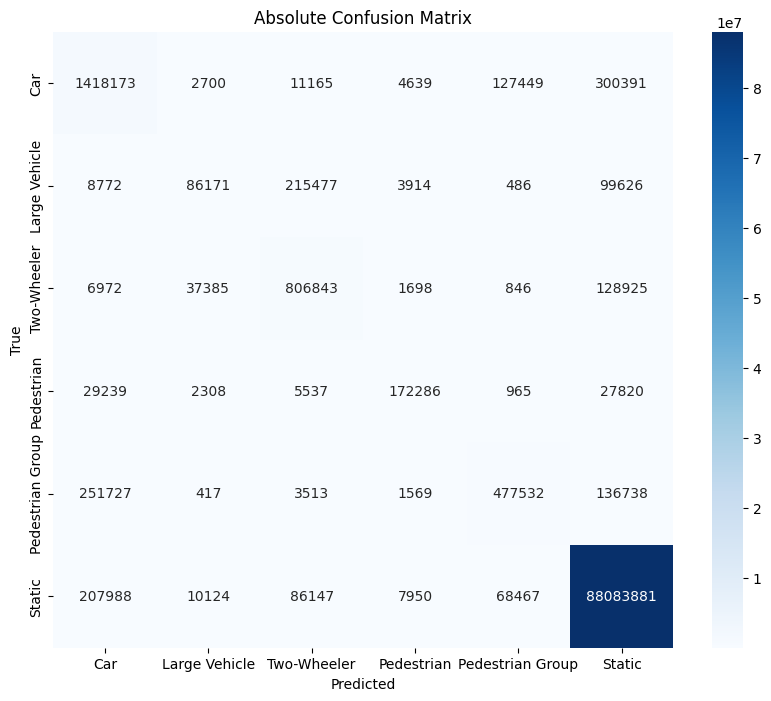

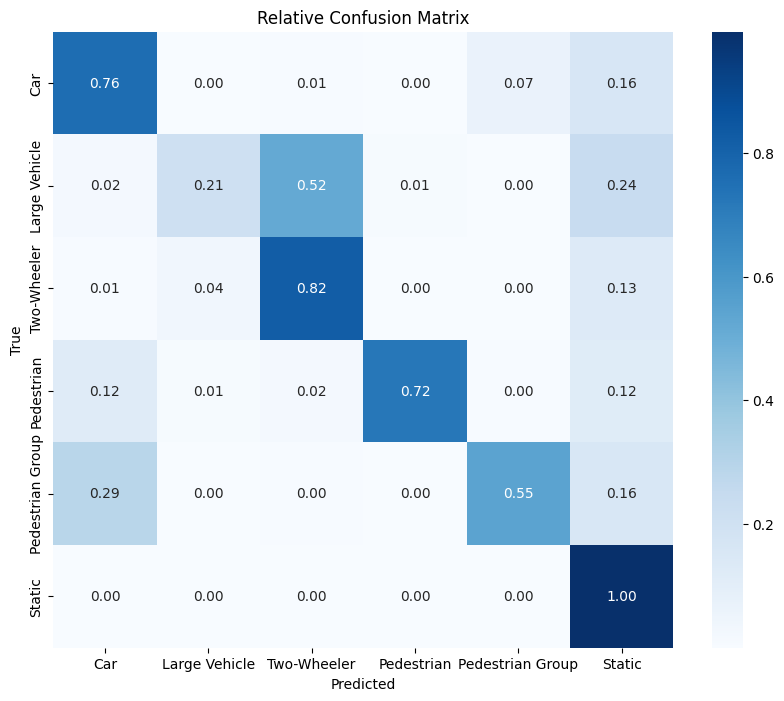

In [27]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

class Trainer:
    def __init__(self, model, dataset, criterion, optimizer, num_epochs=30, batch_size=32, num_folds=5):
        self.model = model
        self.dataset = dataset
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.num_folds = num_folds
        self.confusion_matrices = []

    def train(self):
        kf = KFold(n_splits=self.num_folds, shuffle=True, random_state=42)
        
        for fold, (train_idx, test_idx) in enumerate(kf.split(np.arange(len(self.dataset)))):
            print(f'Fold {fold+1}/{self.num_folds}')
            train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42)  # 0.2 of 80% is 16%

            train_subset = Subset(self.dataset, train_idx)
            val_subset = Subset(self.dataset, val_idx)
            test_subset = Subset(self.dataset, test_idx)

            train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=self.batch_size, shuffle=False)
            test_loader = DataLoader(test_subset, batch_size=self.batch_size, shuffle=False)

            # Ensure the testing flag is set correctly for validation and test subsets
            val_subset.dataset.testing = True
            test_subset.dataset.testing = True

            for epoch in range(self.num_epochs):
                self.model.train()
                running_loss = 0.0
                for point_clouds, labels in tqdm(train_loader):
                    points = torch.stack([pc.clone().detach().requires_grad_(True) for pc in point_clouds]).cuda()
                    labels = labels.cuda()  # Move to GPU if available
                    points = points.transpose(2, 1)
                    self.optimizer.zero_grad()
                    outputs, feat = self.model(points)
                    outputs = outputs.contiguous().view(-1, 6)  # Ensure correct shape [B, num_points, num_classes]
                    labels = labels.view(-1, 1)[:, 0]
                    loss = self.criterion(outputs, labels)  # Compute loss
                    loss.backward()
                    self.optimizer.step()
                    running_loss += loss.item()

                val_loss, val_accuracy, _, _ = self.evaluate(val_loader)
                print(f'Epoch {epoch+1}/{self.num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%')

            test_loss, test_accuracy, f1_score, fold_confusion_mat = self.evaluate(test_loader)
            self.confusion_matrices.append(fold_confusion_mat)
            print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%, Macro-averaged F1 Score: {f1_score:.2f}')

        # Aggregate confusion matrices
        absolute_confusion_matrix = np.sum(self.confusion_matrices, axis=0)
        relative_confusion_matrix = absolute_confusion_matrix / absolute_confusion_matrix.sum(axis=1)[:, np.newaxis]

        print("\nAbsolute Confusion Matrix:\n", absolute_confusion_matrix)
        print("\nRelative Confusion Matrix:\n", relative_confusion_matrix)

        # Plot confusion matrices
        self.plot_confusion_matrix(absolute_confusion_matrix, "Absolute Confusion Matrix")
        self.plot_confusion_matrix(relative_confusion_matrix, "Relative Confusion Matrix", normalize=True)

    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for point_clouds, labels in tqdm(test_loader):
                points = torch.stack([pc.clone().detach() for pc in point_clouds]).cuda()
                labels = labels.cuda()  # Move to GPU if available
                points = points.transpose(2, 1)
                outputs, _ = self.model(points)
                outputs = outputs.contiguous().view(-1, 6) 
                labels = labels.view(-1, 1)[:, 0]
                loss = self.criterion(outputs, labels)  # Compute loss
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total

        # Compute confusion matrix and F1 score
        confusion_mat = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2, 3, 4, 5])
        f1 = evaluate_performance(confusion_mat)

        return total_loss / len(test_loader), accuracy, f1, confusion_mat

    def plot_confusion_matrix(self, cm, title, normalize=False):
        """
        Plots a confusion matrix.
        
        Args:
            cm (np.array): Confusion matrix.
            title (str): Title of the plot.
            normalize (bool): Whether to normalize the values.
        """
        classes = ['Car', 'Large Vehicle', 'Two-Wheeler', 'Pedestrian', 'Pedestrian Group', 'Static']
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

# Example usage
model = get_model(6)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

trainer = Trainer(model, dataset, criterion, optimizer, num_epochs=2, batch_size=32, num_folds=5)
trainer.train()


In [ ]:
final_df_radar = final_df_radar[final_df_radar['label_id'] != 11]

## Frame 
A frame is defined as a collection of points that share the same timestamp, meaning they were all captured at the same exact moment. These points come from a single sensor scan—so think of it like a radar system taking a snapshot of its surroundings, detecting various objects around it in that instant.

Each frame represents a single snapshot in time and contains data from a single radar scan. The labeled points per frame refer to the number of detected points in that snapshot which are identified as belonging to specific objects, like cars, pedestrians, or cyclists. These objects are assigned labels (from 0 to 11) based on what the radar has detected.

### So, in summary:

Frame = Set of radar points from one sensor scan, all captured at the same timestamp.
Labeled points per frame = Count of radar points in a frame that have been assigned a label, identifying what type of object they belong to.

## Snippet:
A snippet is like a short video clip made up of several frames, each frame being a snapshot from the radar sensor. In this case, the snippet covers 500 milliseconds (half a second). Imagine the radar sensor scanning a road for half a second. Every little radar "snapshot" during that time is a frame, and when you put all those frames together over 500 milliseconds, you get a snippet. These snippets are used for training and testing in machine learning models.

## Sequence:
A sequence is a longer video, like a collection of snippets. It’s recorded during a full working cycle of the radar sensor system. This cycle could last as long as the radar is actively scanning a real-world traffic scene, like a busy intersection or a highway. A sequence covers a longer period of time, possibly involving cars stopping at lights, pedestrians crossing, and more. In the RadarScenes dataset, there are 158 sequences, and they vary in how long they are, depending on how long the radar system was running during each cycle.

### To summarize:

Snippet: A short radar video (500 milliseconds long) used for training/testing.
Sequence: A longer radar video capturing a full scene, like traffic on a road. There are 158 sequences in total, each representing different traffic situations.

### Sensor ID: Think of this as a unique name or number given to each radar sensor. It’s like how each player on a sports team has a different jersey number.
### Position (x and y): These are like coordinates on a map. They tell us where each sensor is placed on the car. Imagine you have a toy car, and you place stickers on it. The x and y positions tell you exactly where to put each sticker.
### Yaw-Angle: This is a bit like the direction a sensor is facing. If you think of the car as a compass, the yaw-angle tells you which way the sensor is pointing. It’s like saying, “This sensor is looking north” or “This sensor is looking east.”

In [ ]:
import pandas as pd

## sequences.json
#### Category: Indicates whether the sequence is used for training or validation of machine learning algorithms.
#### Number of Scenes: The total number of individual scenes within the sequence.
#### Duration: The length of the sequence in seconds.
#### Sensors: The names of the sensors that performed measurements within this sequence.
This file helps in organizing and understanding the different sequences recorded in the dataset, making it easier to work with the data for various applications.

# Scene.json

- **Sequence Name**: The name of the sequence.
- **Group**: Indicates whether the sequence is used for training or validation.
- **Timestamps**: The timestamps of the first and last radar sensor measurements in the sequence.
- **Scenes**: Each scene is defined as one measurement from one of the four radar sensors. For each scene, the following information is provided:
  - **Sensor ID**: The ID of the radar sensor that performed the measurement.
  - **Unique Timestamp**: The exact time when the radar sensor took the measurement.
  - **Next and Previous Timestamps**: The next and previous timestamps of measurements from the same sensor and from any radar sensor.
  - **Odometry Information**: The timestamp of the closest odometry measurement and its index in the odometry table.
  - **Camera Image**: The filename of the camera image closest in time to the radar measurement.
  - **Radar Detections**: The start and end indices of the radar detections in the hdf5 dataset.

This file helps in organizing and understanding the data collected by the radar sensors, making it easier to work with the dataset for various applications.
